In [1]:
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys
import pickle 
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import SGD
import corner

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import sys, platform, os
from numpy import sqrt, sin, cos, pi
import scipy.constants as cst

camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0,camb_path)
import camb
from camb import model, initialpower
tf.__version__

'2.8.0'

In [2]:
import scipy.integrate as integrate
import scipy.special as special     
from scipy.interpolate import CubicSpline
from scipy import interpolate
from scipy.optimize import curve_fit
from scipy.integrate import quad, dblquad

In [3]:
train_params = np.load('LHS_params_3dim5000.npz')                  

In [4]:
print(train_params.files)                                       # Each of the keys has an 'np.array' of values

['h', 'omega_b', 'omega_cdm']


In [5]:
#print(train_params['omega_b'])

n_samples = len(train_params['h'])
print('number of training samples: ', len(train_params['omega_b'])) 

number of training samples:  5000


In [6]:
cosmo_params = np.zeros((len(train_params['omega_b']), 3))
print(cosmo_params[199])

cosmo_params[:, 0] = train_params['h']
cosmo_params[:, 1] = train_params['omega_b']
cosmo_params[:, 2] = train_params['omega_cdm']

[0. 0. 0.]


In [7]:
print(cosmo_params[0])
print(cosmo_params[4999])

[0.7015163  0.02092098 0.17426485]
[0.65366673 0.02242208 0.18358672]


In [8]:
len(train_params['h'])

5000

In [9]:
#%%time
## Training input params:
h = cosmo_params[:, 0]
# ombh2:
omega_b = cosmo_params[:, 1]
# omch2:
omega_c = cosmo_params[:, 2]

In [10]:
with open('pk_data_3dim5000.pkl', 'rb') as f:
    pk_matrix = pickle.load(f)

In [11]:
# Training input params and output param:

train_H0 = 100*h                               #1x400                     # np.arrays, sizes len(train_params['h'])
train_omega_b = omega_b                        #1x400
train_omega_c = omega_c                        #1x400
train_pk = pk_matrix                           #400x1400                   # don't need kh, stays the same

In [12]:
input_params = np.vstack([train_H0, train_omega_b, train_omega_c])        # n_samples = no. of rows

input_params_transpose = np.transpose(input_params)
print(np.shape(input_params_transpose))
print(np.shape(train_pk))

input_data = pd.DataFrame(input_params_transpose)
input_data.columns = ['H0', 'Omega_b', 'Omega_cdm']

output_data = pd.DataFrame(train_pk)                                       
print( input_data)                                                         #1400x3
#print(output_data)

(5000, 3)
(5000, 500)
             H0   Omega_b  Omega_cdm
0     70.151630  0.020921   0.174265
1     64.307261  0.018337   0.166783
2     66.784557  0.018113   0.122374
3     75.560712  0.019995   0.203271
4     64.492899  0.021805   0.179906
...         ...       ...        ...
4995  79.942388  0.024654   0.068644
4996  75.595919  0.020550   0.137057
4997  75.947990  0.023314   0.092769
4998  69.361072  0.021008   0.052240
4999  65.366673  0.022422   0.183587

[5000 rows x 3 columns]


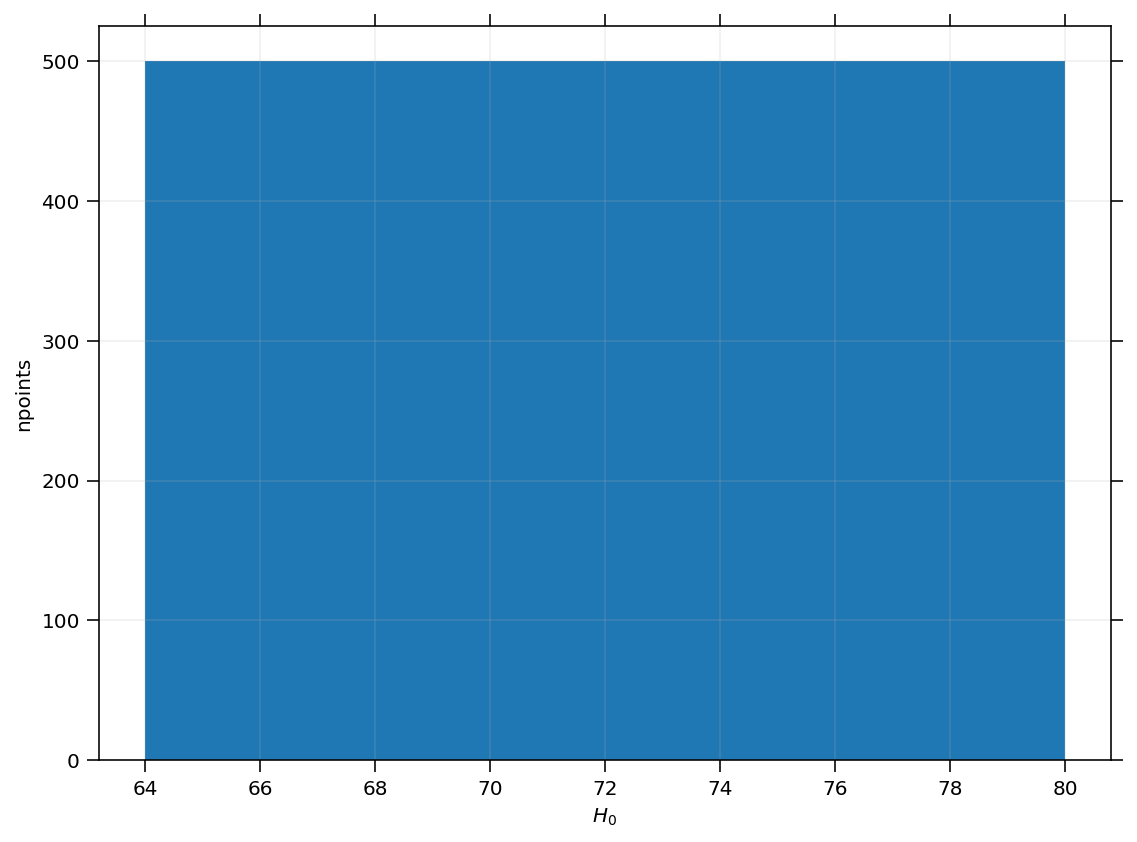

In [13]:
plt.figure(figsize = (8,6))
plt.hist(input_data['H0'])
#plt.hist(input_data['Omega_b'])
#plt.hist(input_data['Omega_cdm'])
plt.xlabel(r'$H_{0}$')
plt.ylabel('npoints')
plt.rc('axes', labelsize=16)
plt.rc('axes', labelsize=20, titlesize=20)
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
plt.grid(alpha=0.2)
plt.grid(alpha=0.2)
plt.tick_params(top=True,right=True, length=6)
plt.tight_layout()

In [14]:
# Standardising:

train_input_data = StandardScaler()
test_output_data = StandardScaler()

scaled_input = train_input_data.fit(input_data.values)
scaled_output = test_output_data.fit(output_data.values)

# Generating the standardized values of input and output:
X = scaled_input.transform(input_data.values)                         
y = scaled_output.transform(output_data.values)                    
print(X)

[[-0.40010374 -0.28648121  0.42019553]
 [-1.66519368 -1.56473473  0.29063813]
 [-1.12895074 -1.67558598 -0.47839244]
 ...
 [ 0.85459389  0.89754875 -0.99107949]
 [-0.57123037 -0.24352635 -1.69290649]
 [-1.43587015  0.45622219  0.58162267]]


-1.7317044320414525 5.832604448749877


(array([[500., 500., 500., 500., 500., 500., 500., 500., 500., 500.],
        [500., 500., 500., 500., 500., 500., 500., 500., 500., 500.],
        [500., 500., 500., 500., 500., 500., 500., 500., 500., 500.]]),
 array([-1.73170443e+00, -1.38536355e+00, -1.03902266e+00, -6.92681773e-01,
        -3.46340886e-01,  4.44089210e-16,  3.46340886e-01,  6.92681773e-01,
         1.03902266e+00,  1.38536355e+00,  1.73170443e+00]),
 <a list of 3 BarContainer objects>)

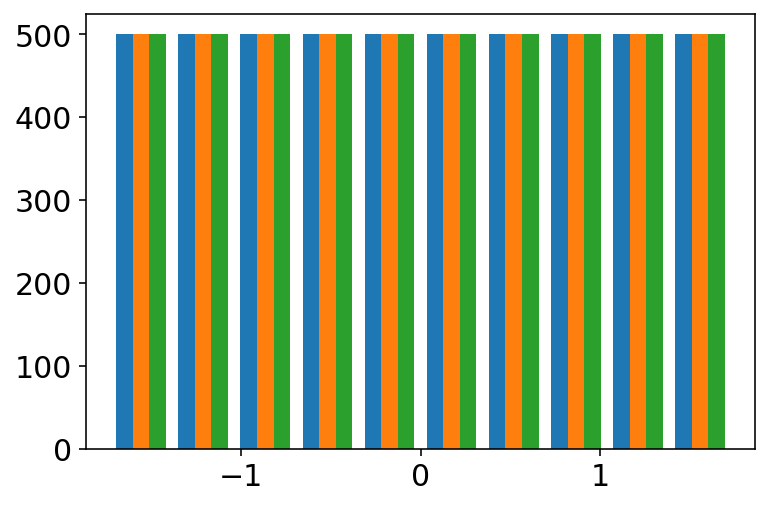

In [15]:
print(X.min(), y.max())
plt.hist(X)

In [70]:
# Split the data into training and testing sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(np.shape(X_train))    # 4000x3
print(X_train.shape[1])     # 3

(4000, 3)
3


In [71]:
print(X_train)

[[-0.28024583  0.1465315   1.19615431]
 [-1.52801525  0.38278324  1.4989168 ]
 [-0.98761539  0.43890168  1.07352511]
 ...
 [ 0.59755754 -0.41950271 -0.18671508]
 [-0.85390107 -1.62362446  1.15597073]
 [-0.80124672 -1.47605373 -0.92456874]]


In [72]:
print("y_test samples, pts:", np.shape(y_test))
print("y_train samples, pts:", np.shape(y_train))
print("X_train samples, pts:", np.shape(X_train))
print("X_test ssamples, pts:",np.shape(X_test))
print("X_train:", X_train)
print("X_test:", X_test)

y_test samples, pts: (1000, 500)
y_train samples, pts: (4000, 500)
X_train samples, pts: (4000, 3)
X_test ssamples, pts: (1000, 3)
X_train: [[-0.28024583  0.1465315   1.19615431]
 [-1.52801525  0.38278324  1.4989168 ]
 [-0.98761539  0.43890168  1.07352511]
 ...
 [ 0.59755754 -0.41950271 -0.18671508]
 [-0.85390107 -1.62362446  1.15597073]
 [-0.80124672 -1.47605373 -0.92456874]]
X_test: [[-0.4361304  -0.10149818 -0.65783291]
 [-0.8518226   1.56265627  1.20723944]
 [-0.54906012  0.95228155  1.56750601]
 ...
 [ 0.62527035 -0.28024583  0.74304981]
 [-1.09084562  1.48713885  0.40148939]
 [-1.41300708  0.82549543  0.54906012]]


In [73]:
%%time
#Building the NN:

tf_model = Sequential()
# Defining the input layer of the model
tf_model.add(Dense(units=500, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
 
# Defining 1st Hidden layer of the model
tf_model.add(Dense(units=500, kernel_initializer='normal', activation='relu'))

tf_model.add(Dropout(0.1))

# Defining 2nd Hidden layer of the model
tf_model.add(Dense(units=500, kernel_initializer='normal', activation='relu'))

# Defining 3rd Hidden layer of the model
#tf_model.add(Dense(units=500, kernel_initializer='normal', activation='relu'))

# Defining the 4th hidden layer of the model
#tf_model.add(Dense(units=350, kernel_initializer='normal', activation='relu')) 


#Defining the output layer of the model
tf_model.add(Dense(500, kernel_initializer='normal'))
 
opt = keras.optimizers.Adam(learning_rate=2e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0) 
    
# Compiling the model
tf_model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])
 
# Fitting the ANN to the Training set
hist_ = tf_model.fit(X_train, y_train, batch_size = 50, epochs = 500, validation_split=0.2, verbose=1)
            
# Mean absolute percentage error
MAPE = np.mean(np.abs((y_test - tf_model.predict(X_test))/y_test))*100
print(np.shape(100-MAPE))
print('Accuracy:', 100-MAPE)
#89.73150593184755, l_rate = 8e-5, 500 epochs, 350 units
#74.14350129190194 l_rate=3e-5, 500 epochs, 500 units
#86.70889317753266 l_rate =2e-05, 500 epochs, 500 units

tf_model.summary()

Epoch 1/500
64/64 [==============================] - 1s 9ms/step - loss: 0.9943 - accuracy: 0.0022 - val_loss: 0.9871 - val_accuracy: 0.0025
Epoch 2/500
64/64 [==============================] - 0s 8ms/step - loss: 0.9491 - accuracy: 0.0037 - val_loss: 0.9112 - val_accuracy: 0.0000e+00
Epoch 3/500
64/64 [==============================] - 0s 7ms/step - loss: 0.8231 - accuracy: 3.1250e-04 - val_loss: 0.7162 - val_accuracy: 0.0000e+00
Epoch 4/500
64/64 [==============================] - 0s 7ms/step - loss: 0.5735 - accuracy: 0.0000e+00 - val_loss: 0.4242 - val_accuracy: 0.0000e+00
Epoch 5/500
64/64 [==============================] - 1s 9ms/step - loss: 0.3331 - accuracy: 3.1250e-04 - val_loss: 0.2558 - val_accuracy: 0.0000e+00
Epoch 6/500
64/64 [==============================] - 0s 7ms/step - loss: 0.2296 - accuracy: 0.0000e+00 - val_loss: 0.1995 - val_accuracy: 0.0012
Epoch 7/500
64/64 [==============================] - 0s 7ms/step - loss: 0.1921 - accuracy: 6.2500e-04 - val_loss: 0.1755 

64/64 [==============================] - 0s 7ms/step - loss: 0.0238 - accuracy: 0.1509 - val_loss: 0.0208 - val_accuracy: 0.2138
Epoch 59/500
64/64 [==============================] - 0s 7ms/step - loss: 0.0232 - accuracy: 0.1691 - val_loss: 0.0205 - val_accuracy: 0.2163
Epoch 60/500
64/64 [==============================] - 1s 8ms/step - loss: 0.0230 - accuracy: 0.1619 - val_loss: 0.0189 - val_accuracy: 0.2362
Epoch 61/500
64/64 [==============================] - 0s 7ms/step - loss: 0.0217 - accuracy: 0.1775 - val_loss: 0.0186 - val_accuracy: 0.2400
Epoch 62/500
64/64 [==============================] - 0s 7ms/step - loss: 0.0217 - accuracy: 0.1713 - val_loss: 0.0186 - val_accuracy: 0.2500
Epoch 63/500
64/64 [==============================] - 0s 7ms/step - loss: 0.0207 - accuracy: 0.1875 - val_loss: 0.0176 - val_accuracy: 0.2537
Epoch 64/500
64/64 [==============================] - 1s 8ms/step - loss: 0.0201 - accuracy: 0.1894 - val_loss: 0.0170 - val_accuracy: 0.2587
Epoch 65/500
64/64 

64/64 [==============================] - 0s 7ms/step - loss: 0.0077 - accuracy: 0.3247 - val_loss: 0.0057 - val_accuracy: 0.4062
Epoch 116/500
64/64 [==============================] - 0s 7ms/step - loss: 0.0078 - accuracy: 0.3231 - val_loss: 0.0051 - val_accuracy: 0.4025
Epoch 117/500
64/64 [==============================] - 0s 7ms/step - loss: 0.0073 - accuracy: 0.3212 - val_loss: 0.0050 - val_accuracy: 0.4162
Epoch 118/500
64/64 [==============================] - 0s 7ms/step - loss: 0.0072 - accuracy: 0.3309 - val_loss: 0.0049 - val_accuracy: 0.4150
Epoch 119/500
64/64 [==============================] - 0s 7ms/step - loss: 0.0073 - accuracy: 0.3375 - val_loss: 0.0050 - val_accuracy: 0.4288
Epoch 120/500
64/64 [==============================] - 0s 8ms/step - loss: 0.0072 - accuracy: 0.3291 - val_loss: 0.0050 - val_accuracy: 0.4325
Epoch 121/500
64/64 [==============================] - 0s 7ms/step - loss: 0.0070 - accuracy: 0.3388 - val_loss: 0.0047 - val_accuracy: 0.4300
Epoch 122/500

64/64 [==============================] - 0s 7ms/step - loss: 0.0040 - accuracy: 0.4078 - val_loss: 0.0019 - val_accuracy: 0.4888
Epoch 173/500
64/64 [==============================] - 0s 7ms/step - loss: 0.0039 - accuracy: 0.4122 - val_loss: 0.0021 - val_accuracy: 0.4812
Epoch 174/500
64/64 [==============================] - 0s 7ms/step - loss: 0.0040 - accuracy: 0.4119 - val_loss: 0.0018 - val_accuracy: 0.4975
Epoch 175/500
64/64 [==============================] - 0s 7ms/step - loss: 0.0039 - accuracy: 0.4228 - val_loss: 0.0018 - val_accuracy: 0.4900
Epoch 176/500
64/64 [==============================] - 0s 7ms/step - loss: 0.0038 - accuracy: 0.4162 - val_loss: 0.0019 - val_accuracy: 0.5075
Epoch 177/500
64/64 [==============================] - 0s 7ms/step - loss: 0.0038 - accuracy: 0.4147 - val_loss: 0.0019 - val_accuracy: 0.4975
Epoch 178/500
64/64 [==============================] - 0s 7ms/step - loss: 0.0040 - accuracy: 0.4222 - val_loss: 0.0020 - val_accuracy: 0.5362
Epoch 179/500

64/64 [==============================] - 0s 7ms/step - loss: 0.0029 - accuracy: 0.4541 - val_loss: 0.0010 - val_accuracy: 0.5713
Epoch 230/500
64/64 [==============================] - 0s 7ms/step - loss: 0.0027 - accuracy: 0.4569 - val_loss: 0.0011 - val_accuracy: 0.5612
Epoch 231/500
64/64 [==============================] - 0s 7ms/step - loss: 0.0028 - accuracy: 0.4462 - val_loss: 0.0011 - val_accuracy: 0.5738
Epoch 232/500
64/64 [==============================] - 0s 7ms/step - loss: 0.0027 - accuracy: 0.4581 - val_loss: 0.0010 - val_accuracy: 0.5975
Epoch 233/500
64/64 [==============================] - 0s 7ms/step - loss: 0.0027 - accuracy: 0.4547 - val_loss: 0.0010 - val_accuracy: 0.5375
Epoch 234/500
64/64 [==============================] - 0s 7ms/step - loss: 0.0027 - accuracy: 0.4459 - val_loss: 0.0011 - val_accuracy: 0.5500
Epoch 235/500
64/64 [==============================] - 0s 7ms/step - loss: 0.0026 - accuracy: 0.4597 - val_loss: 0.0010 - val_accuracy: 0.5713
Epoch 236/500

64/64 [==============================] - 0s 7ms/step - loss: 0.0022 - accuracy: 0.4859 - val_loss: 8.0062e-04 - val_accuracy: 0.6050
Epoch 286/500
64/64 [==============================] - 0s 7ms/step - loss: 0.0022 - accuracy: 0.4809 - val_loss: 8.2264e-04 - val_accuracy: 0.6137
Epoch 287/500
64/64 [==============================] - 1s 8ms/step - loss: 0.0022 - accuracy: 0.4837 - val_loss: 7.6132e-04 - val_accuracy: 0.6225
Epoch 288/500
64/64 [==============================] - 0s 7ms/step - loss: 0.0022 - accuracy: 0.4712 - val_loss: 7.7530e-04 - val_accuracy: 0.5950
Epoch 289/500
64/64 [==============================] - 1s 8ms/step - loss: 0.0022 - accuracy: 0.4950 - val_loss: 7.4814e-04 - val_accuracy: 0.6062
Epoch 290/500
64/64 [==============================] - 0s 7ms/step - loss: 0.0020 - accuracy: 0.4797 - val_loss: 6.8204e-04 - val_accuracy: 0.6237
Epoch 291/500
64/64 [==============================] - 0s 7ms/step - loss: 0.0022 - accuracy: 0.4916 - val_loss: 8.8895e-04 - val_ac

Epoch 341/500
64/64 [==============================] - 0s 7ms/step - loss: 0.0019 - accuracy: 0.5156 - val_loss: 5.6204e-04 - val_accuracy: 0.6388
Epoch 342/500
64/64 [==============================] - 0s 7ms/step - loss: 0.0018 - accuracy: 0.5078 - val_loss: 5.8357e-04 - val_accuracy: 0.6275
Epoch 343/500
64/64 [==============================] - 0s 7ms/step - loss: 0.0019 - accuracy: 0.4944 - val_loss: 5.3770e-04 - val_accuracy: 0.6313
Epoch 344/500
64/64 [==============================] - 0s 7ms/step - loss: 0.0019 - accuracy: 0.5194 - val_loss: 5.5643e-04 - val_accuracy: 0.6388
Epoch 345/500
64/64 [==============================] - 0s 7ms/step - loss: 0.0018 - accuracy: 0.5241 - val_loss: 5.1868e-04 - val_accuracy: 0.6275
Epoch 346/500
64/64 [==============================] - 0s 7ms/step - loss: 0.0019 - accuracy: 0.5153 - val_loss: 7.5776e-04 - val_accuracy: 0.6288
Epoch 347/500
64/64 [==============================] - 0s 7ms/step - loss: 0.0019 - accuracy: 0.5125 - val_loss: 6.008

Epoch 397/500
64/64 [==============================] - 0s 7ms/step - loss: 0.0016 - accuracy: 0.5119 - val_loss: 4.1131e-04 - val_accuracy: 0.6687
Epoch 398/500
64/64 [==============================] - 0s 7ms/step - loss: 0.0016 - accuracy: 0.5384 - val_loss: 5.0247e-04 - val_accuracy: 0.6500
Epoch 399/500
64/64 [==============================] - 0s 7ms/step - loss: 0.0016 - accuracy: 0.5291 - val_loss: 4.2429e-04 - val_accuracy: 0.6425
Epoch 400/500
64/64 [==============================] - 0s 7ms/step - loss: 0.0016 - accuracy: 0.5312 - val_loss: 4.3271e-04 - val_accuracy: 0.6400
Epoch 401/500
64/64 [==============================] - 0s 7ms/step - loss: 0.0016 - accuracy: 0.5366 - val_loss: 4.7111e-04 - val_accuracy: 0.6562
Epoch 402/500
64/64 [==============================] - 0s 7ms/step - loss: 0.0017 - accuracy: 0.5406 - val_loss: 3.9463e-04 - val_accuracy: 0.6450
Epoch 403/500
64/64 [==============================] - 0s 7ms/step - loss: 0.0017 - accuracy: 0.5206 - val_loss: 4.743

Epoch 453/500
64/64 [==============================] - 1s 8ms/step - loss: 0.0014 - accuracy: 0.5441 - val_loss: 3.6813e-04 - val_accuracy: 0.6637
Epoch 454/500
64/64 [==============================] - 1s 8ms/step - loss: 0.0015 - accuracy: 0.5569 - val_loss: 6.8007e-04 - val_accuracy: 0.6575
Epoch 455/500
64/64 [==============================] - 0s 7ms/step - loss: 0.0016 - accuracy: 0.5425 - val_loss: 3.8636e-04 - val_accuracy: 0.6550
Epoch 456/500
64/64 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.5403 - val_loss: 5.3070e-04 - val_accuracy: 0.6662
Epoch 457/500
64/64 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.5403 - val_loss: 3.5683e-04 - val_accuracy: 0.6625
Epoch 458/500
64/64 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.5487 - val_loss: 3.6375e-04 - val_accuracy: 0.6625
Epoch 459/500
64/64 [==============================] - 0s 7ms/step - loss: 0.0014 - accuracy: 0.5434 - val_loss: 3.622

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

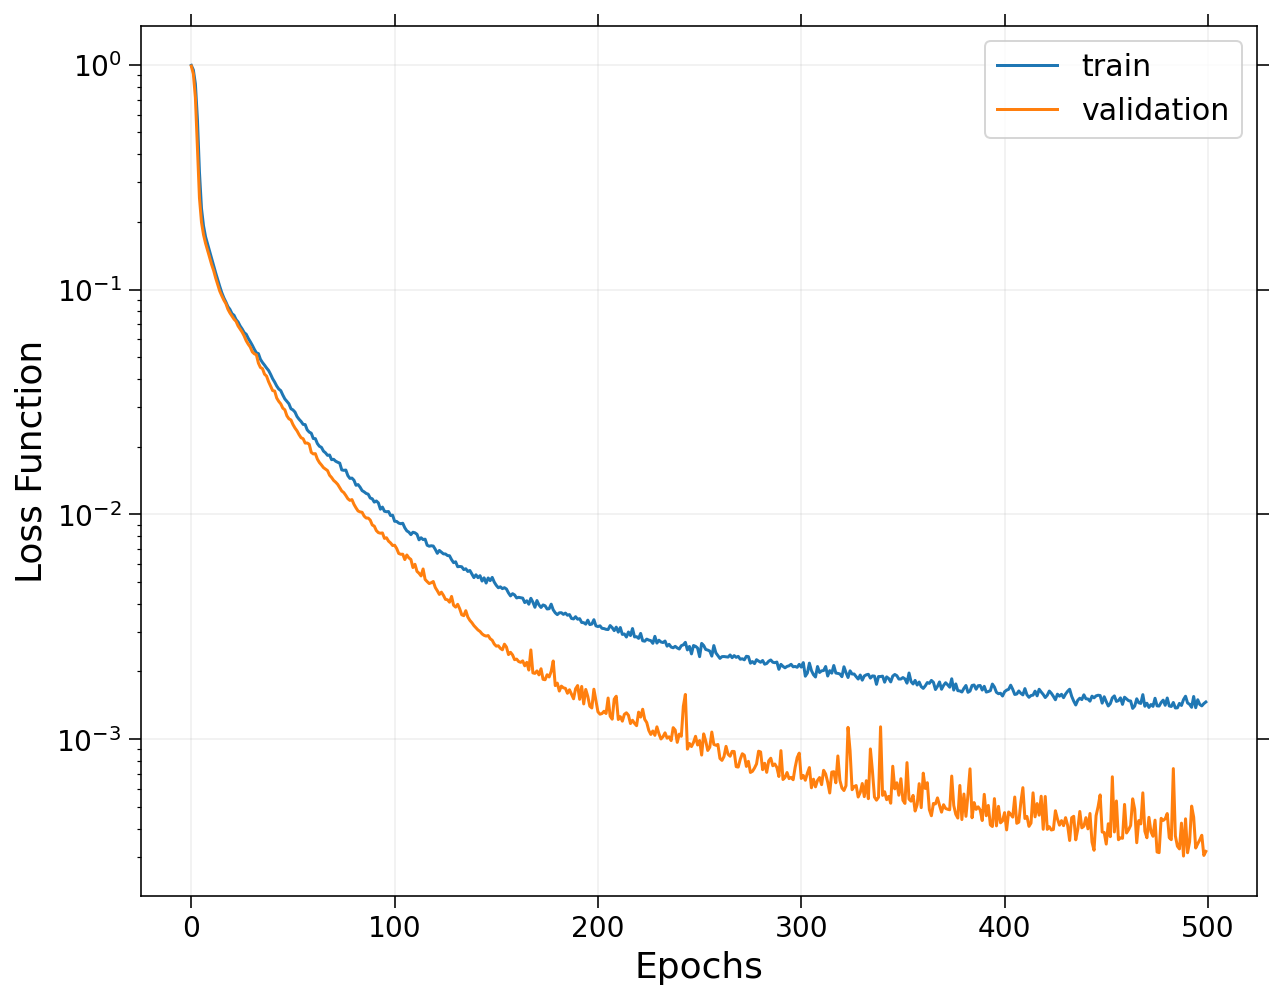

In [74]:
plt.figure(figsize = (10,8))
plt.plot(hist_.history["loss"], label="train")
plt.plot(hist_.history["val_loss"], label="validation")
plt.legend(fontsize=15)
plt.yscale("log")
plt.xlabel('Epochs')
plt.ylabel('Loss Function')
plt.rc('axes', labelsize=16)
plt.rc('axes', labelsize=20, titlesize=20)
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
plt.grid(alpha=0.2)
plt.grid(alpha=0.2)
plt.tick_params(top=True,right=True, length=6)
#plt.savefig('Loss_Func_3param.jpg')
plt.tight_layout

H0: 62.0 - 78.0, Omega_b: 0.0180 - 0.0250, Omega_cdm: 0.050 - 0.250 67.66 0.022 0.119


parameters:  ['67.66', '0.022', '0.119']
user_list: [67.66, 0.022, 0.119]
cosmo_arr [[6.766e+01 2.200e-02 1.190e-01]]
cosmo_arr[0] [6.766e+01 2.200e-02 1.190e-01]
input_scaled [[-0.93944965  0.24738635 -0.53682837]]
H0: 67.66 Omega_b: 0.022 Omega_c: 0.119


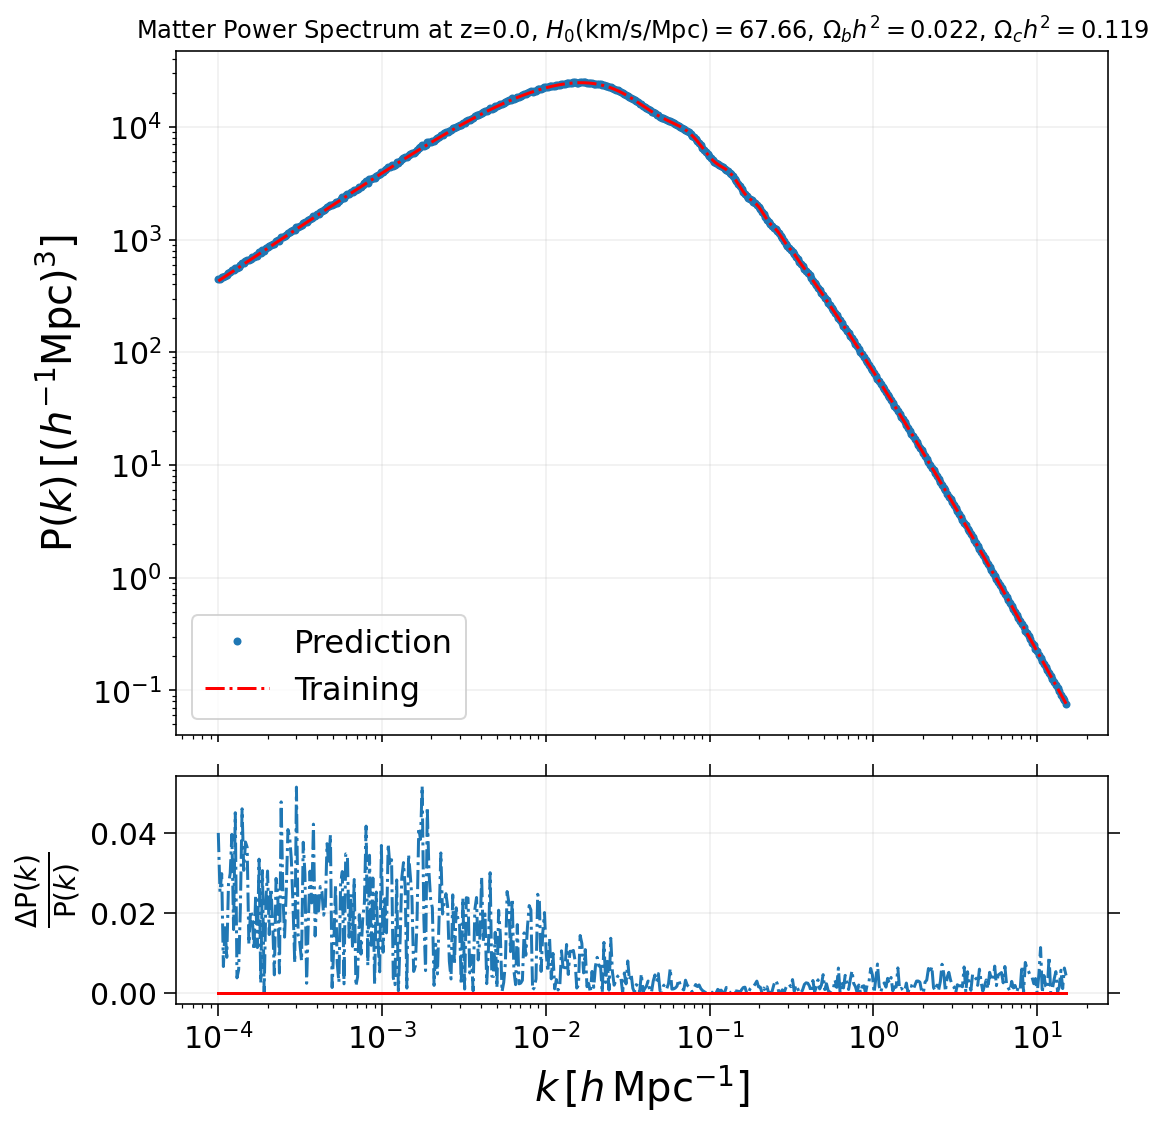

In [75]:
#Define func:

def calc_cosmo():
    input_cosmo_val = input('H0: 62.0 - 78.0, Omega_b: 0.0180 - 0.0250, Omega_cdm: 0.050 - 0.250 ')
    print("\n")
    user_list = input_cosmo_val.split()
    print('parameters: ', user_list)

    # convert each item to float type
    for i in range(len(user_list)):
        # convert each item to float type
        user_list[i] = float(user_list[i])
    print("user_list:", user_list)
        
    
    cosmo_arr = np.reshape(np.array(user_list),(1, X_train.shape[1]))
    print('cosmo_arr', cosmo_arr)
    print('cosmo_arr[0]', cosmo_arr[0])
    scaled = train_input_data.fit(input_data.values)
    input_scaled = scaled.transform(cosmo_arr)
    print('input_scaled', input_scaled)
    
    pred_pk = scaled_output.inverse_transform(tf_model.predict([input_scaled]))

    
    #Compute P.S via CAMB:
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=cosmo_arr[0][0], ombh2=cosmo_arr[0][1], omch2=cosmo_arr[0][2])
    pars.InitPower.set_params(As = 2.105209331e-9, ns=0.9665)
    pars.set_matter_power(redshifts=[0.0], kmax=15.0)
    pars.set_dark_energy(w=-1.0, wa=0, dark_energy_model='fluid')

    # Linear spectra
    pars.NonLinear = model.NonLinear_none
    results = camb.get_results(pars)
    camb_kh, z, camb_pk_cur = results.get_matter_power_spectrum(minkh=1e-4, maxkh=15, npoints=500)
    s8_current = np.array(results.get_sigma8())
    s8_fid = np.array([0.8102])
    renorm_s8 = (s8_fid/s8_current)**2
    camb_pk = renorm_s8*camb_pk_cur
    

    print('H0:' , cosmo_arr[0][0], 'Omega_b:', cosmo_arr[0][1], 'Omega_c:', cosmo_arr[0][2])
    #print(pred_pk)
    
    fig, ax = plt.subplots(2,1, sharex=True, figsize = (8,8), gridspec_kw={'height_ratios': [3, 1]})                                            
    ax[0].loglog(camb_kh, pred_pk[0], "C0.")                                                           # prediction              
    ax[0].loglog(camb_kh, camb_pk[0], 'r', linestyle='dashdot')                                        # CAMB            
    ax[0].set_title('Matter Power Spectrum at z=0.0, $H_{0} \mathregular{(km/s/Mpc)} = %0.5s$, ' %cosmo_arr[0][0] + '$\Omega_{b}h^{2} = %0.6s$, ' %cosmo_arr[0][1] + '$\Omega_{c}h^{2} = %0.6s$' %cosmo_arr[0][2], fontsize = 12)
    plt.rc('axes', labelsize=18)
    plt.rc('axes', titlesize=16)
    plt.rcParams['xtick.labelsize']=14
    plt.rcParams['ytick.labelsize']=14
    plt.xlabel(r'$k\,[h\,\mathrm{Mpc}^{-1}]$')
    ax[0].set_ylabel(r'$\mathrm{P}(k)\, [(h^{-1}\mathrm{Mpc})^{3}]$')
    ax[0].legend(['Prediction', 'Training'], loc='lower left', fontsize=16);
    ax[0].grid(alpha=0.2)
    ax[1].grid(alpha=0.2)
    plt.tick_params(top=True,right=True, length=6)
    
    #residual plot 
    ax[1].set_ylabel(r'$\frac{\Delta \mathrm{P}(k)}{\mathrm{P}(k)}$')
    ax[1].plot(camb_kh, np.abs((pred_pk[0]-camb_pk[0])/camb_pk[0]), 'C0', linestyle="dashdot") 
    ax[1].plot(camb_kh, np.abs((camb_pk[0]-camb_pk[0])/camb_pk[0]), 'r')
    ax[1].set_yscale('linear')
    #ax[1].set_ylim(0, 0.5)
    fig.tight_layout()
    #plt.savefig('NN_MPS_3param.jpg')
    plt.show()
    
    

Generate = calc_cosmo()
#67.5 0.024 0.15